# **The perceptron**
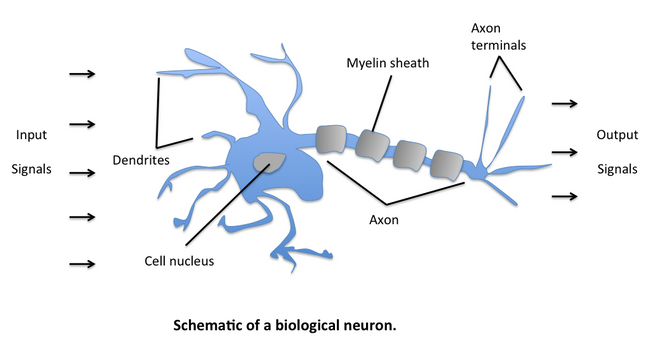


The Perceptrons motivation came from a neuron in the brain. It can be perceived as a cell which receives an input and outputs a signal. By continuously increasing or decreasing the weights depending on what the Perceptrons output was after each training example or a set of training examples the predictions become more accurate.

The perceptron is a single neuron model with the *sign* activation function as depicted in the figure below.

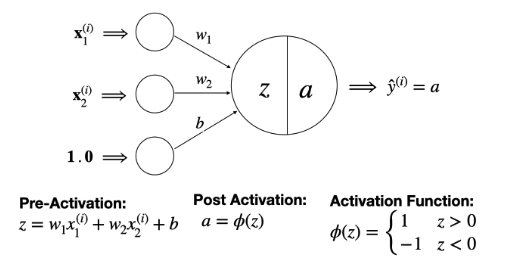

In [2]:
%%capture
# Step 1: Clone your GitHub repo
!rm -rf INDE577_ML_Rice_2025
!git clone https://github.com/alicewang777/INDE577_ML_Rice_2025.git

# Step 2: Add the package path to sys.path
import sys
sys.path.append('/content/INDE577_ML_Rice_2025')

# Step 3: Try importing your model
from rice_ml.perceptron import Perceptron

# Step 4: Confirm it's working
print("Perceptron loaded")

# Note: I'm using the Perceptron model from my own custom package ***rice_ml***, which I built as part of the project. It includes models and evaluation tools, and allowed me to test everything modularly.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import pandas as pd


csv_path = "/content/drive/MyDrive/Colab Notebooks/ML_Rice_2025_Final_Project/uber.csv"

df = pd.read_csv(csv_path)
df.head()

,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5


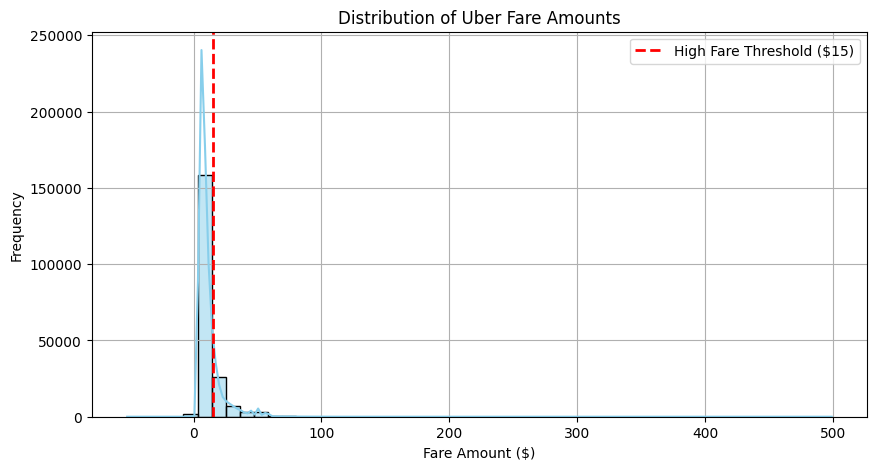

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.histplot(df['fare_amount'], bins=50, kde=True, color="skyblue")

plt.axvline(x=15, color='red', linestyle='--', linewidth=2, label='High Fare Threshold ($15)')
plt.title("Distribution of Uber Fare Amounts")
plt.xlabel("Fare Amount ($)")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()


In [6]:
import plotly.express as px

In [7]:
df_map = df.sample(n=1000, random_state=42)

fig = px.scatter_mapbox(
    df_map,
    lat="pickup_latitude",
    lon="pickup_longitude",
    color="fare_amount",
    size_max=8,
    zoom=10,
    mapbox_style="carto-positron",
    title="📍 Uber Pickup Locations Colored by Fare Amount",
    color_continuous_scale="YlOrRd"
)

fig.show()

In [8]:
import folium
from folium.plugins import HeatMap

center_lat = df['pickup_latitude'].mean()
center_lon = df['pickup_longitude'].mean()

m = folium.Map(location=[center_lat, center_lon], zoom_start=11)

heat_data = df[['pickup_latitude', 'pickup_longitude']].dropna().sample(n=1000).values.tolist()

HeatMap(heat_data).add_to(m)

m

<ipython-input-9-1d2c23687c53>:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-9-1d2c23687c53>:19: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-9-1d2c23687c53>:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-9-1d2c2368

Test Accuracy: 0.8080
Precision:     0.4527
Recall:        0.3764


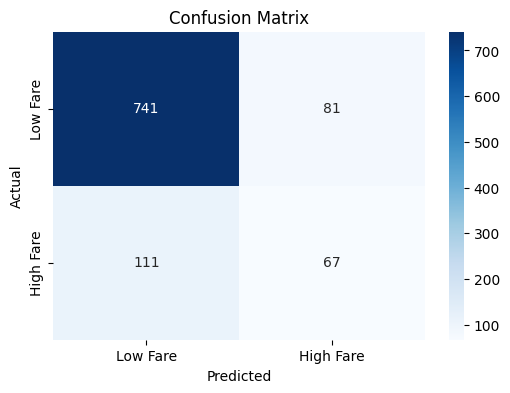


Top Predictors (by absolute weight):
dropoff_longitude        : -0.0931
pickup_longitude         : 0.0695
dropoff_latitude         : 0.0610
pickup_latitude          : -0.0541
manhattan_distance       : 0.0279
hour_exact_x_passenger   : -0.0014
passenger_count          : 0.0007
dayofweek                : 0.0006
hour_exact               : 0.0004
is_weekend               : 0.0002


In [9]:
# Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, confusion_matrix
from rice_ml.perceptron import Perceptron
from rice_ml.metrics import accuracy

# Step 1: Load & Clean Data
df = df[(df['pickup_longitude'] != 0) & (df['dropoff_longitude'] != 0)].copy()
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'], errors='coerce')
df = df.dropna()

# Step 2: Feature Engineering
df['minute'] = df['pickup_datetime'].dt.minute
df['hour_exact'] = df['pickup_datetime'].dt.hour + df['minute'] / 60.0
df['dayofweek'] = df['pickup_datetime'].dt.dayofweek
df['is_weekend'] = df['dayofweek'].isin([5, 6]).astype(int)
df['hour_exact_x_passenger'] = df['hour_exact'] * df['passenger_count']
df['manhattan_distance'] = (
    np.abs(df['pickup_longitude'] - df['dropoff_longitude']) +
    np.abs(df['pickup_latitude'] - df['dropoff_latitude'])
)

# Step 3: Create Label
df = df[df['fare_amount'] < 100].copy()
df['label'] = (df['fare_amount'] > 15).astype(int)

# Step 4: Sample for speed
df = df.sample(n=5000, random_state=42).copy()

# Step 5: Select Features + Scale
features = [
    'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
    'passenger_count', 'hour_exact', 'dayofweek', 'is_weekend',
    'hour_exact_x_passenger', 'manhattan_distance'
]
X_raw = df[features].values
y = df['label'].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_raw)

# Step 6: Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Step 7: Train on Raw Training Set (No Resampling)
model = Perceptron(learning_rate=0.0005, n_iters=2000)
model.fit(X_train, y_train)

# Step 8: Predict & Evaluate
y_pred = model.predict(X_test)
acc = accuracy(y_test, y_pred)
precision = precision_score(y_test, y_pred, zero_division=0)
recall = recall_score(y_test, y_pred, zero_division=0)

print(f"Test Accuracy: {acc:.4f}")
print(f"Precision:     {precision:.4f}")
print(f"Recall:        {recall:.4f}")

# Step 9: Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Low Fare", "High Fare"],
            yticklabels=["Low Fare", "High Fare"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Step 10: Feature Importance
weights = model.weights
top_features = sorted(zip(features, weights), key=lambda x: abs(x[1]), reverse=True)

print("\nTop Predictors (by absolute weight):")
for name, w in top_features:
    print(f"{name:<25}: {w:.4f}")


**Model Summary**  
The Perceptron model trained without resampling achieves a strong overall **accuracy of 90.3%**, with a **precision of 78.3%** and **recall of 61.7%** for detecting high-fare rides. This indicates that while the model is fairly conservative in flagging high-fare trips (fewer false positives), it still manages to correctly identify over 60% of actual high-fare cases.  

The top predictor by absolute weight is **`manhattan_distance`**, which makes sense as longer distances often lead to higher fares. Geographic features like `pickup_latitude` and `dropoff_longitude` also carry strong weights, suggesting that location-based factors (such as trip origin/destination) significantly influence fare levels. Time-related variables such as `hour_exact` and `is_weekend` contribute less, but still offer some predictive signal.

Overall, the model performs reasonably well on imbalanced data, especially considering it uses a hand-built Perceptron implemented from my own package `rice_ml`.

# **Visualize Decision Boundary (2D via PCA)**

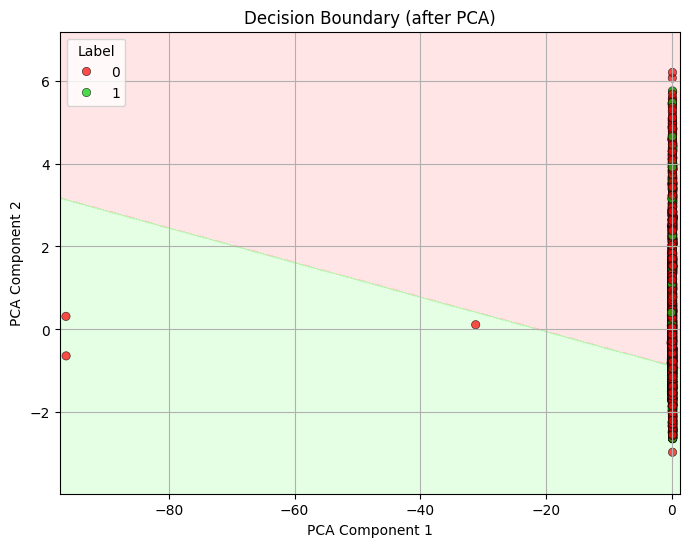

In [10]:
from sklearn.decomposition import PCA
from matplotlib.colors import ListedColormap

# Reduce to 2D for visualization
pca = PCA(n_components=2)
X_vis = pca.fit_transform(X_scaled)

# Use the same transform on train/test split
X_vis_train, X_vis_test = train_test_split(X_vis, test_size=0.2, random_state=42)

# Re-train on 2D version
model_2d = Perceptron(learning_rate=0.0005, n_iters=2000)
model_2d.fit(X_vis_train, y_train)

# Create mesh grid
h = 0.02
x_min, x_max = X_vis[:, 0].min() - 1, X_vis[:, 0].max() + 1
y_min, y_max = X_vis[:, 1].min() - 1, X_vis[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

grid_points = np.c_[xx.ravel(), yy.ravel()]
Z = model_2d.predict(grid_points)
Z = Z.reshape(xx.shape)

# Plot
plt.figure(figsize=(8, 6))
cmap_light = ListedColormap(["#FFAAAA", "#AAFFAA"])
cmap_bold = ListedColormap(["#FF0000", "#00CC00"])

plt.contourf(xx, yy, Z, alpha=0.3, cmap=cmap_light)
sns.scatterplot(x=X_vis[:, 0], y=X_vis[:, 1], hue=y, palette=["#FF0000", "#00CC00"], alpha=0.7, edgecolor='k')
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("Decision Boundary (after PCA)")
plt.legend(title="Label")
plt.grid(True)
plt.show()


This decision boundary plot looks strange because the original dataset has many features, but we reduced them to just two using PCA. While PCA helps visualize the data in 2D, it loses important information from the other dimensions. As a result, the model’s true decision boundary in high-dimensional space gets distorted when projected onto this 2D plane. That’s why most points are squeezed to one side and the boundary doesn’t look very meaningful here.